In [ ]:
# default_exp monte_carlo_eth2

# Monte Carlo on ETH2 Scenarios


In [ ]:
#export
from nbdev.showdoc import *
import jovsatools
import fastcore
import numpy as np
from collections import Counter, defaultdict
from tqdm import tqdm
import seaborn as sns
from typing import Optional, List
import pandas as pd
import matplotlib.pyplot as plt

### Setup Code

In [ ]:
class NumpyDist:
    """Numpy Random Sampling Distribution 
    
    list of distributions: https://numpy.org/doc/1.16/reference/routines.random.html
    """
    def __init__(self, dist, params:dict):
        self.dist = dist
        self.params = params
        self.dry_run() # basic check
        
    def dry_run(self):
        """Ensures that dist and params can be called correctly. """
        try:
            self.__call__()
        except Exception as e:
            raise e
    
    def __call__(self):
        return self.dist(**self.params)

class MonteCarlo:
    def __init__(self, input_dists, seed):
        assert isinstance(input_dists, dict)
        self.input_dists = input_dists
        self.seed = np.random.seed(seed)

    def _get_sample(self):
        _inputs = dict()
        for name, dist in self.input_dists.items():
            _inputs[name] = dist()
        return _inputs
            
    def run(self, iters:int, constants:Optional[dict]=None):
        stats = defaultdict(list)

        for i in tqdm(range(iters)):
            
            # setup
            _sample = self._get_sample()
            staking_return = _sample['staking_return_pct']
            voo_return = 1+_sample['voo_returns']
            total_staked = constants['curr_eth_price'] * constants['total_eth_staked']
            gross_returns = staking_return * total_staked
            tax_due = constants['tax_rate'] * gross_returns
            sampled_eth_value = _sample['eth_price'] * constants['total_eth_staked']
            
            # consts
            tot_costs = constants['aws_cost'] + tax_due
            
            # returns
            net_returns = gross_returns - tot_costs            
            
            # opportunity costs
            eth_opportunity_cost = sampled_eth_value - total_staked
            usd_opportunity_cost = (voo_return*total_staked) - total_staked
            
            
            # logging calculations
            stats['staking_return'].append(staking_return)
            stats['voo_return'].append(voo_return)
            stats['gross_returns'].append(gross_returns)
            stats['total_staked'].append(total_staked)
            stats['sampled_eth_price'].append(_sample['eth_price'])
            stats['sampled_eth_value'].append(sampled_eth_value)
            stats['net_returns'].append(net_returns)
            stats['tax_due'].append(tax_due)
            stats['tot_costs'].append(tot_costs)
            # note: only inlcude opportunity cost if > 0
            stats['ETH_opportunity_cost'].append(max(0, eth_opportunity_cost))
            stats['USD_opportunity_cost'].append(max(0, usd_opportunity_cost))
            stats['total_opportunity_cost'].append(max(0, eth_opportunity_cost, usd_opportunity_cost))
            
        return pd.DataFrame.from_dict(stats)

### ETH Specific Values

In [ ]:
# per year estimates
input_dists = {
    # based on online probability from staking calculator [1]
    # online probability = [left=80%, mode=85%, right=99%]
    'staking_return_pct': NumpyDist(dist=np.random.triangular, params={"left":0.0466, "mode":0.056, "right":0.0857}),    
    
    # price returns: triangular
    'eth_price': NumpyDist(dist=np.random.triangular,  params={"left":1000, "mode":2000, "right":5000}),
    
    # In the last 10 years, the Vanguard S&P 500 (VOO) ETF obtained a 13.38% compound annual return, with a 13.45% standard deviation [3]
    'voo_returns': NumpyDist(dist=np.random.normal, params={"loc":0.1338, "scale":0.1345}),
}

constants = {
    # c5.xlarge costs $0.17 per Hour [2]
    'aws_cost': 1489.2, #=0.17*24*365
    'tax_rate': 0.35,
    'curr_eth_price': 1700,
    'total_eth_staked': 32 
}

mc = MonteCarlo(input_dists=input_dists, seed=4096)
stats = mc.run(iters=1_000_000, constants=constants)

100%|██████████| 1000000/1000000 [00:10<00:00, 92371.32it/s]


### Analyzing Results

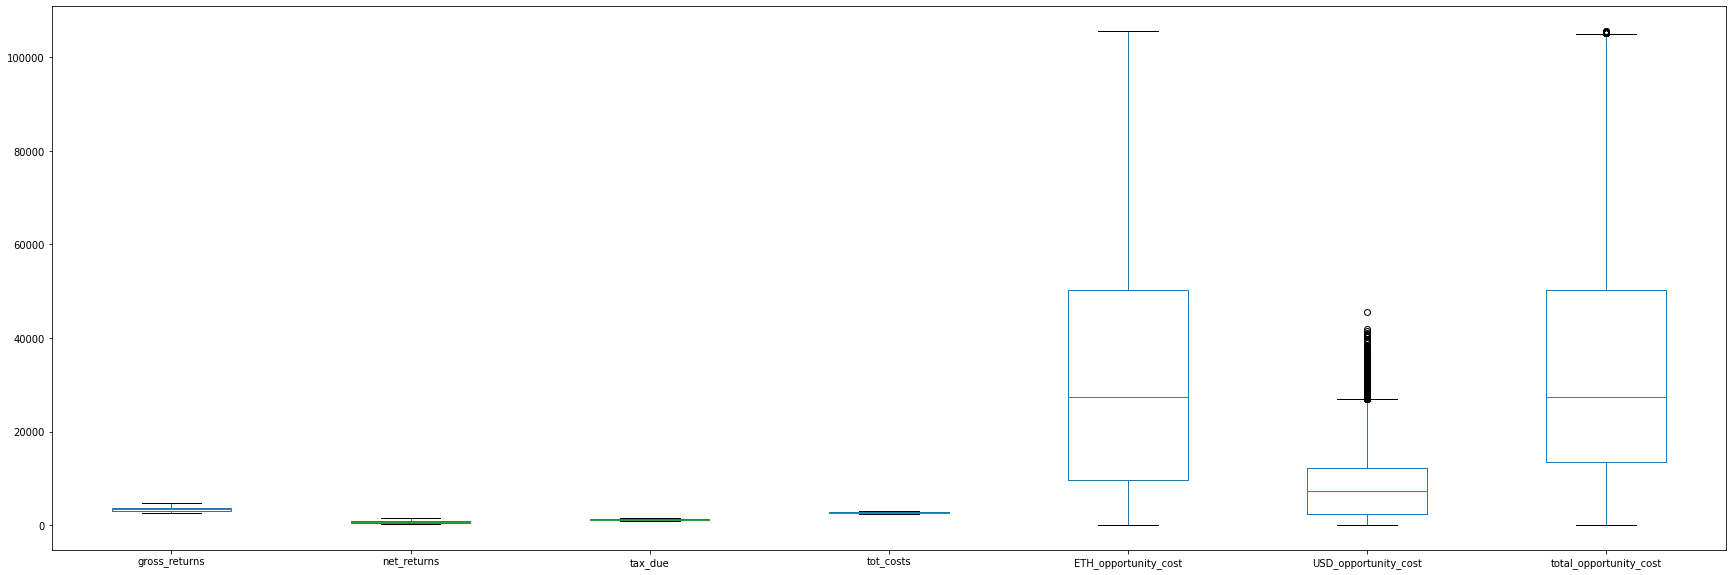

In [ ]:
COLS_TO_PLOT = ['gross_returns', 'net_returns', 'tax_due', 
                'tot_costs', 'ETH_opportunity_cost', 
                'USD_opportunity_cost', 'total_opportunity_cost']

stats[COLS_TO_PLOT].plot.box()
plt.rcParams['figure.figsize'] = [30, 10]

In [ ]:
stats.describe()

,staking_return,voo_return,gross_returns,total_staked,sampled_eth_price,sampled_eth_value,net_returns,tax_due,tot_costs,ETH_opportunity_cost,USD_opportunity_cost,total_opportunity_cost
count,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.062756,1.133756,3413.935641,54400.0,2667.407221,85357.031087,729.858167,1194.877474,2684.077474,31874.745006,7891.258050,33508.662837
std,0.008331,0.134441,453.197006,0.0,850.039564,27201.266032,294.578054,158.618952,158.618952,25922.464336,6331.785832,24328.359309
min,0.046615,0.472167,2535.873767,54400.0,1001.162693,32037.206190,159.117948,887.555818,2376.755818,0.000000,0.000000,0.000000
25%,0.056178,1.042953,3056.106247,54400.0,2001.021899,64032.700777,497.269061,1069.637187,2558.837187,9632.700777,2336.621455,13556.680628
50%,0.061594,1.133764,3350.694774,54400.0,2553.339563,81706.866032,688.751603,1172.743171,2661.943171,27306.866032,7276.741674,27421.476152
75%,0.068655,1.224347,3734.827811,54400.0,3266.926896,104541.660682,938.438077,1307.189734,2796.389734,50141.660682,12204.470840,50141.660682
max,0.085697,1.836364,4661.923900,54400.0,4998.636053,159956.353693,1541.050535,1631.673365,3120.873365,105556.353693,45498.227591,105556.353693


### References

* [1] [staking calculator](https://beaconcha.in/calculator)
* [2] [AWS pricing](https://aws.amazon.com/ec2/pricing/on-demand/)
* [3] [VOO - S&P returns](http://www.lazyportfolioetf.com/etf/vanguard-sp-500-voo/#:~:text=In%20the%20last%2010%20years,granted%20a%201.81%25%20dividend%20yield.) 